# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score
import copy

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, UpSampling1D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import feature_extraction_lib as ftelib

# Input Files

In [2]:
# Load the train and validation datasets
train_df = pd.read_pickle('../train_ludb.pkl')
val_df = pd.read_pickle('../validation_ludb.pkl')

# Convert the loaded Dataframes to numpy arrays
train_data = train_df[['Patient ID', 'Hilbert', 'Shannon', 'Homomorphic', 'Hamming', 'Labels']].to_numpy()
val_data = val_df[['Patient ID', 'Hilbert', 'Shannon', 'Homomorphic', 'Hamming', 'Labels']].to_numpy()

## Declare data pepare

In [3]:
BATCH_SIZE = 32
patch_size = 64
nch = 4
stride = 8

train_features, train_labels = ftelib.process_dataset(train_data, patch_size, stride)
val_features, val_labels = ftelib.process_dataset(val_data, patch_size, stride)

# Training Pipeline

In [4]:
def unet_ecg(nch, patch_size, dropout=0.05):
    inputs = tf.keras.layers.Input(shape=(patch_size, nch))
    conv1 = tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)
    pool1 = tf.keras.layers.Dropout(dropout)(pool1)

    conv2 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv2)
    pool2 = tf.keras.layers.Dropout(dropout)(pool2)

    conv3 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv3)
    pool3 = tf.keras.layers.Dropout(dropout)(pool3)

    conv4 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv4)
    pool4 = tf.keras.layers.Dropout(dropout)(pool4)

    conv5 = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(conv5)

    up6_prep = tf.keras.layers.UpSampling1D(size=2)(conv5)

    up6 = tf.keras.layers.concatenate([tf.keras.layers.Conv1D(64, 2, padding='same')(up6_prep), conv4], axis=2)
    up6 = tf.keras.layers.Dropout(dropout)(up6)
    conv6 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(up6)
    conv6 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(conv6)

    up7_prep = tf.keras.layers.UpSampling1D(size=2)(conv6)

    up7 = tf.keras.layers.concatenate([tf.keras.layers.Conv1D(64, 2, padding='same')(up7_prep), conv3], axis=2)
    up7 = tf.keras.layers.Dropout(dropout)(up7)
    conv7 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(up7)
    conv7 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(conv7)

    up8_prep = tf.keras.layers.UpSampling1D(size=2)(conv7)

    up8 = tf.keras.layers.concatenate([tf.keras.layers.Conv1D(32, 2, padding='same')(up8_prep), conv2], axis=2)
    up8 = tf.keras.layers.Dropout(dropout)(up8)
    conv8 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(up8)
    conv8 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(conv8)

    up9_prep = tf.keras.layers.UpSampling1D(size=2)(conv8)

    up9 = tf.keras.layers.concatenate([tf.keras.layers.Conv1D(8, 2, padding='same')(up9_prep), conv1], axis=2)
    up9 = tf.keras.layers.Dropout(dropout)(up9)
    conv9 = tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same')(up9)
    conv9 = tf.keras.layers.Conv1D(8, 3, activation='tanh', padding='same')(conv9)

    conv10 = tf.keras.layers.Conv1D(4, 1, activation='softmax')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])
    return model

In [5]:
checkpoint_path = '../ecg_unet_weights/checkpoint.keras'

## Hyperparameter Settings

In [6]:
EPOCHS = 15
learning_rate = 1e-4
model = unet_ecg(nch, patch_size=patch_size)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy',
              metrics=['CategoricalAccuracy', 'Precision', 'Recall'])

In [7]:
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
history = model.fit(train_features, train_labels,
                    validation_data=(val_features, val_labels),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    shuffle=True, callbacks=[model_checkpoint])

Epoch 1/15
2286/2286 [==============================] - 333s 145ms/step - loss: 0.6108 - categorical_accuracy: 0.7865 - precision: 0.8223 - recall: 0.7198 - val_loss: 0.3334 - val_categorical_accuracy: 0.8918 - val_precision: 0.9015 - val_recall: 0.8776
Epoch 2/15
2286/2286 [==============================] - 353s 154ms/step - loss: 0.3804 - categorical_accuracy: 0.8563 - precision: 0.8637 - recall: 0.8455 - val_loss: 0.2755 - val_categorical_accuracy: 0.8963 - val_precision: 0.9009 - val_recall: 0.8904
Epoch 3/15
2286/2286 [==============================] - 371s 162ms/step - loss: 0.3352 - categorical_accuracy: 0.8653 - precision: 0.8694 - recall: 0.8599 - val_loss: 0.2513 - val_categorical_accuracy: 0.9002 - val_precision: 0.9028 - val_recall: 0.8967
Epoch 4/15
2286/2286 [==============================] - 374s 163ms/step - loss: 0.3132 - categorical_accuracy: 0.8712 - precision: 0.8738 - recall: 0.8678 - val_loss: 0.2379 - val_categorical_accuracy: 0.9033 - val_precision: 0.9050 - val

In [8]:
model.load_weights(checkpoint_path)

# Inference Pipeline

Collect the predicions of the U-NET

In [9]:
predictions_train = model.predict(train_features)
predictions_val = model.predict(val_features)

584/584 [==============================] - 3s 5ms/step


# Post Processing

In [10]:
def reconstruct_original_data(patched_data, original_lengths, patch_size, stride):
    """
    Reconstruct the original sequences from patched data.

    Parameters
    ----------
    patched_data : numpy.ndarray
        Patched data array of shape (Num_Patches, Patch_Size, Num_Features).
    original_lengths : list
        List of original lengths for each patient sequence.
    patch_size : int
        The number of samples for each patch.
    stride : int
        The number of samples to stride between patches.

    Returns
    -------
    reconstructed_data : list of numpy.ndarray
        List containing the reconstructed data for each patient.
    """
    reconstructed_data = []
    current_idx = 0

    for original_length in original_lengths:
        # Initialize arrays to hold the reconstructed sequence and overlap count
        reconstructed = np.zeros((original_length, patched_data.shape[-1]))
        overlap_count = np.zeros(original_length)

        num_patches = int(np.floor((original_length - patch_size) / stride)) + 1
        adjusted_stride_samples = (
            (original_length - patch_size) / (num_patches - 1)
            if num_patches > 1 else stride
        )
        adjusted_stride_samples = int(round(adjusted_stride_samples))

        # Iterate over patches and reconstruct the sequence
        for i in range(num_patches):
            start_idx = i * adjusted_stride_samples
            end_idx = min(start_idx + patch_size, original_length)

            reconstructed[start_idx:end_idx] += patched_data[current_idx, :end_idx - start_idx, :]
            overlap_count[start_idx:end_idx] += 1

            current_idx += 1

        # Average the overlapping regions
        reconstructed /= np.maximum(overlap_count[:, None], 1)
        reconstructed_data.append(reconstructed)

    return reconstructed_data


original_lengths = [len(seq) for seq in val_data[:, 1]]  # Get original lengths from validation data
reconstructed_labels = reconstruct_original_data(predictions_val, original_lengths, patch_size, stride)

## Evaluation - Schmidt Metrics

In [12]:
def reverse_one_hot_encoding(one_hot_encoded_data, desired_order=[0, 1, 2, 3]):
    """
    Reverse the one-hot encoding to get the original labels.

    Parameters
    ----------
    one_hot_encoded_data : numpy.ndarray
        One-hot encoded data of shape (Num_Samples, Num_Classes).
    desired_order : list
        List representing the label order used during one-hot encoding.

    Returns
    -------
    labels : numpy.ndarray
        Array of decoded labels of shape (Num_Samples,).
    """
    # Use argmax to find the index of the maximum value in each one-hot encoded row
    label_indices = np.argmax(one_hot_encoded_data, axis=1)
    labels = np.array([desired_order[idx] for idx in label_indices])
    return labels


original_lengths = [len(seq) for seq in val_data[:, 1]]  # Get original lengths from validation data
reconstructed_labels = reconstruct_original_data(predictions_val, original_lengths, patch_size, stride)

pred_labels = [reverse_one_hot_encoding(pred) for pred in reconstructed_labels]

prediction_labels = copy.deepcopy(pred_labels)

ground_truth = [reverse_one_hot_encoding(pred) for pred in val_data[:, 5]]

predictions = np.array([prediction for prediction in prediction_labels], dtype=object)

In [13]:
def extract_state_runs(labels, desired_states):
    """
    Extract continuous runs of the desired states from labels.

    Args:
        labels: numpy array of labels.
        desired_states: set of desired state values.

    Returns:
        A list of dictionaries with keys:
            'start': start index of the run
            'end': end index of the run (inclusive)
            'midpoint': midpoint index of the run
            'state': the state value (0 or 2)
    """
    # Ensure labels is a 1D array
    labels = np.asarray(labels).flatten()

    runs = []
    N = len(labels)
    in_run = False
    run_start = 0
    run_state = None

    for i in range(N):
        label_i = labels[i]
        # If label_i is an array (e.g., from a structured array), extract scalar
        if isinstance(label_i, np.ndarray):
            label_i = label_i.item()
        if label_i in desired_states:
            if not in_run:
                # Start of a new run
                in_run = True
                run_start = i
                run_state = label_i
        else:
            if in_run:
                # End of the run
                run_end = i - 1
                midpoint = (run_start + run_end) // 2
                runs.append({
                    'start': run_start,
                    'end': run_end,
                    'midpoint': midpoint,
                    'state': run_state
                })
                in_run = False
                run_state = None
    # Check if we're still in a run at the end
    if in_run:
        run_end = N - 1
        midpoint = (run_start + run_end) // 2
        runs.append({
            'start': run_start,
            'end': run_end,
            'midpoint': midpoint,
            'state': run_state
        })
    return runs

def compute_ppv_sensitivity(ground_truth, predictions, sample_rate, threshold=60e-3):
    """
    Compute PPV and sensitivity for states 0 and 2.

    Args:
        ground_truth: numpy array of ground truth labels.
        predictions: numpy array of predicted labels.
        sample_rate: sampling rate in Hz.

    Returns:
        ppv: Positive Predictive Value.
        sensitivity: Sensitivity (Recall).
    """
    # Ensure ground_truth and predictions are 1D arrays
    ground_truth = np.asarray(ground_truth).flatten()
    predictions = np.asarray(predictions).flatten()

    # Desired states
    desired_states = {0, 2}

    # Maximum distance in samples (treshold in seconds vs fs)
    max_distance_samples = int(threshold * sample_rate)

    # Extract runs from ground truth and predictions
    gt_runs = extract_state_runs(ground_truth, desired_states)
    pred_runs = extract_state_runs(predictions, desired_states)

    # Get midpoints and states
    gt_midpoints = np.array([run['midpoint'] for run in gt_runs])
    gt_states = np.array([run['state'] for run in gt_runs])

    pred_midpoints = np.array([run['midpoint'] for run in pred_runs])
    pred_states = np.array([run['state'] for run in pred_runs])

    # Initialize matches
    matched_gt_indices = set()
    matched_pred_indices = set()

    # Build potential matches
    potential_matches = []
    for i, (p_mid, p_state) in enumerate(zip(pred_midpoints, pred_states)):
        for j, (gt_mid, gt_state) in enumerate(zip(gt_midpoints, gt_states)):
            if gt_state == p_state:
                distance = abs(p_mid - gt_mid)
                if distance <= max_distance_samples:
                    potential_matches.append((i, j, distance))

    # Sort potential matches by distance
    potential_matches.sort(key=lambda x: x[2])

    # Perform matching
    TP = 0
    for i, j, d in potential_matches:
        if i not in matched_pred_indices and j not in matched_gt_indices:
            matched_pred_indices.add(i)
            matched_gt_indices.add(j)
            TP += 1

    # Compute FP and FN
    total_pred = len(pred_midpoints)
    total_gt = len(gt_midpoints)
    FP = total_pred - len(matched_pred_indices)
    FN = total_gt - len(matched_gt_indices)

    # Compute PPV and Sensitivity
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0

    return ppv, sensitivity

# Example usage:
# Assuming you have numpy arrays `ground_truth_labels` and `predicted_labels`, and `sample_rate`.

# ground_truth_labels = np.array([...])  # Your ground truth labels
# predicted_labels = np.array([...])     # Your predicted labels
# sample_rate = 1000  # Example sample rate in Hz


def compute_schmidt_metrics(ground_truth, sequences, sample_rate):
  ppvs, sensitivities, accuracies = [], [], []
  for i in range(len(ground_truth)):
    ppv, sensitivity = compute_ppv_sensitivity(ground_truth[i],
                                               sequences[i],
                                               50)
    ppvs.append(ppv)
    sensitivities.append(sensitivity)
    accuracies.append(accuracy_score(ground_truth[i], sequences[i]))
  return np.array(ppvs), np.array(sensitivities), np.array(accuracies)


ppv, sens, acc = compute_schmidt_metrics(ground_truth, predictions, 50)

# Inspect Results

In [14]:
def visualize_predictions(ground_truth, seqs, idx):

  # Define the window width in terms of seconds and convert to the corresponding sample range
  window_duration = 0.1  # 0.06 ms in seconds
  sample_interval = 1 / 50  # Time per sample in seconds (20 ms per sample at 50 Hz)

  # Calculate the equivalent width in terms of sample indices (will be <1)
  window_width_samples = window_duration / sample_interval

  # Create the plot
  plt.figure(figsize=(24, 6))

  # Plot ground truth and predictions with discrete markers and dotted lines
  plt.plot(ground_truth[idx], 'o--', label='Ground Truth', markersize=6)
  plt.plot(seqs[idx], 'o--', color='red', label='Predictions', markersize=6)


  # Set labels and legend
  plt.title(f'Signal at idx {idx} with 0.06 ms reference window')
  plt.xlabel('Sample Index')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.grid(True)
  plt.show()

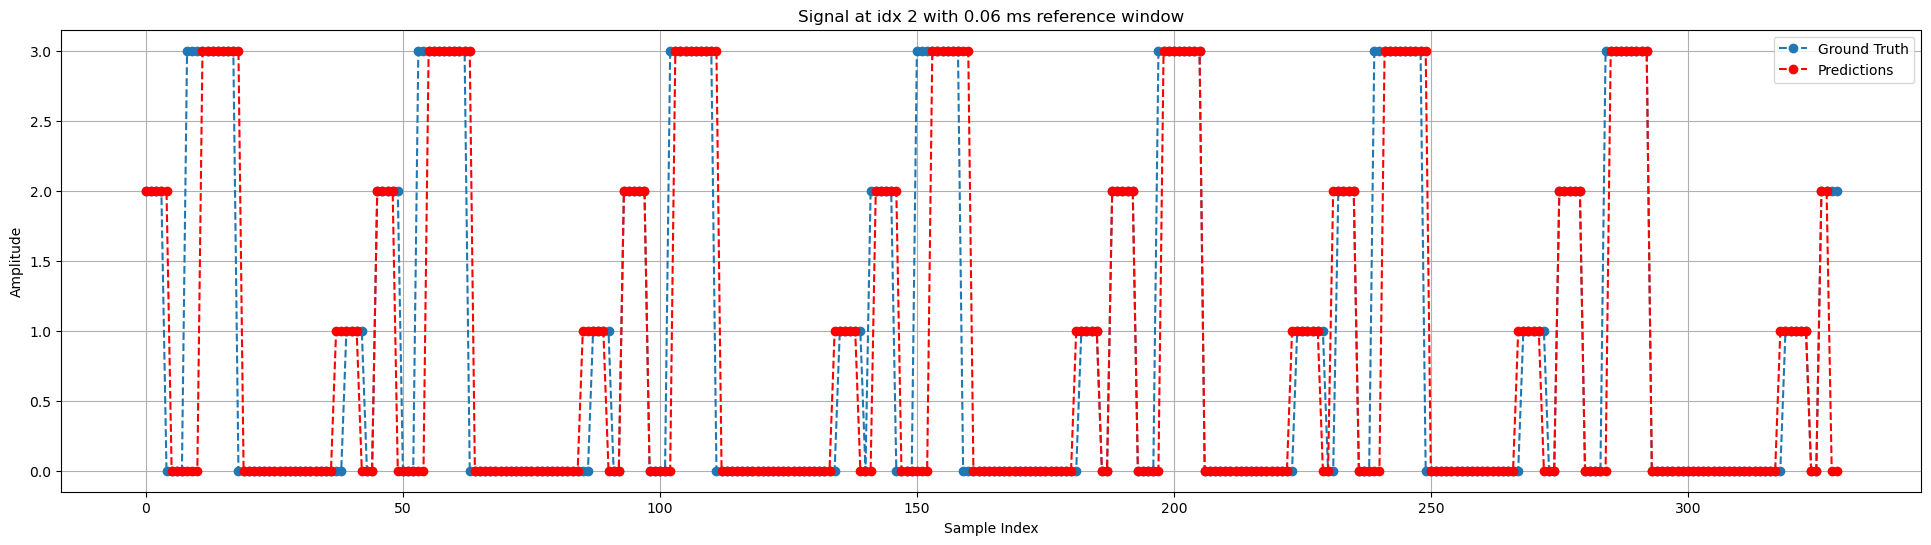

(1.0, 1.0, 0.8787878787878788)

In [15]:
idx = 2
visualize_predictions(ground_truth, predictions, idx)
ppv[idx], sens[idx], acc[idx]

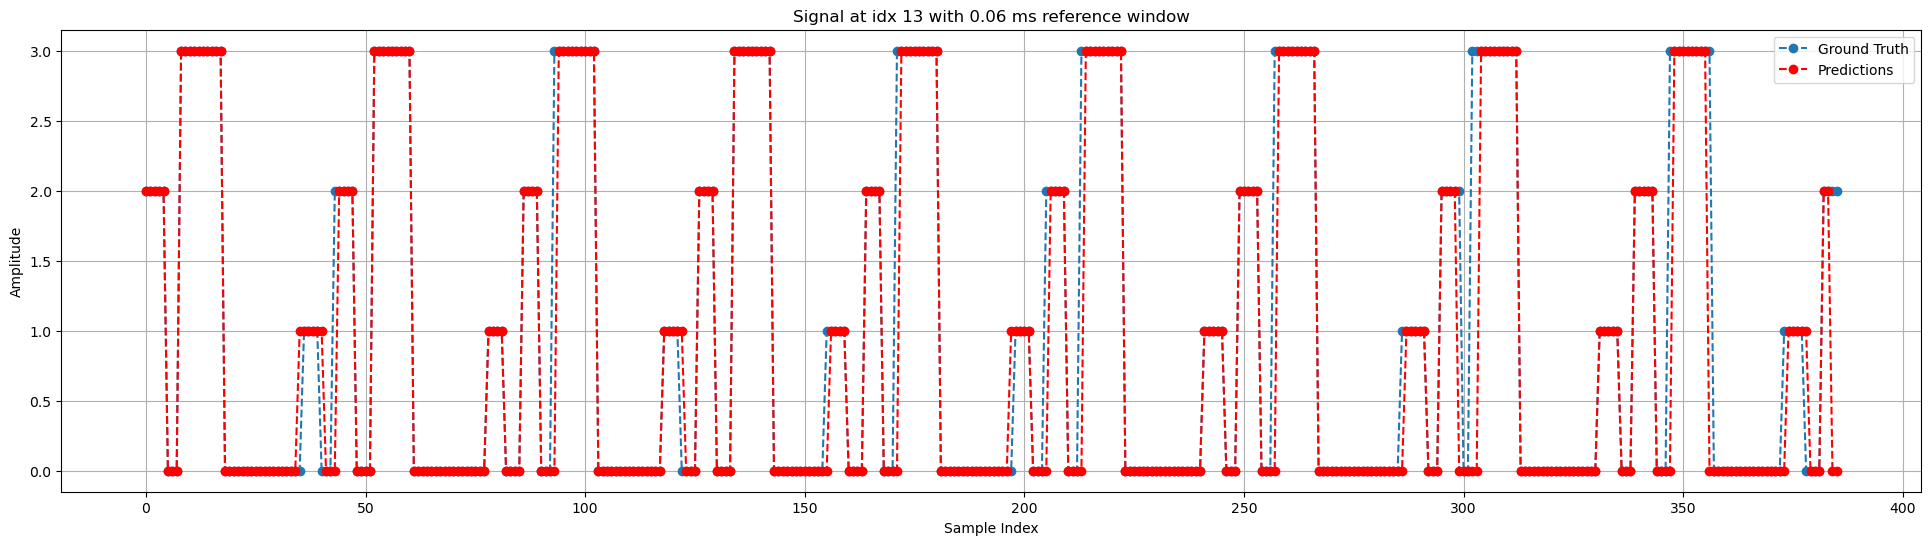

(1.0, 1.0, 0.9455958549222798)

In [16]:
idx = 13
visualize_predictions(ground_truth, predictions, idx)
ppv[idx], sens[idx], acc[idx]

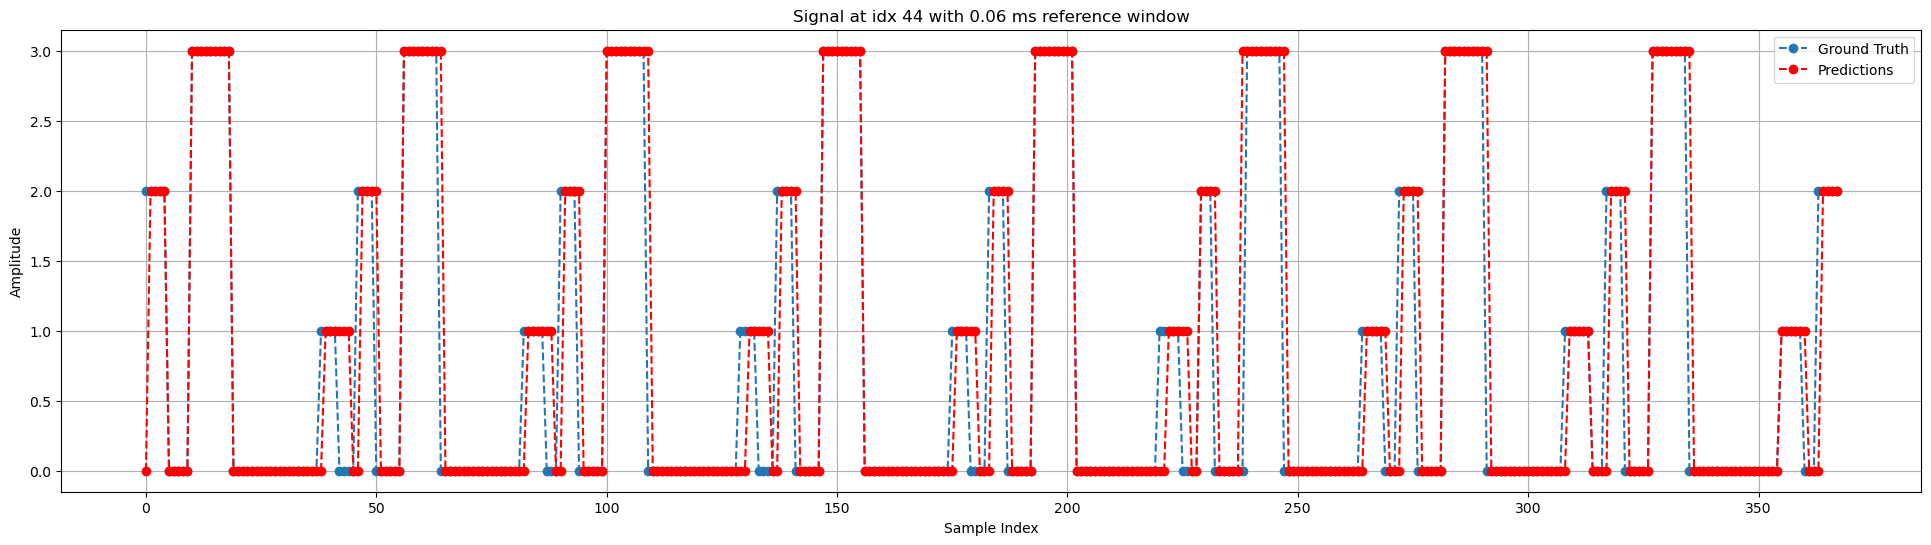

(0.9411764705882353, 0.9411764705882353, 0.8804347826086957)

In [17]:
idx = 44
visualize_predictions(ground_truth, predictions, idx)
ppv[idx], sens[idx], acc[idx]

In [18]:
# Mean and Standard Deviation of metrics
ppv_mean = np.mean(ppv)
ppv_stdev = np.std(ppv)
sens_mean = np.mean(sens)
sens_stdev = np.std(sens)
acc_mean = np.mean(acc)
acc_stdev = np.std(acc)

print("\nppv_mean", ppv_mean)
print("\nppv_stdev", ppv_stdev)
print("\nsens_mean", sens_mean)
print("\nsens_stdev", sens_stdev)
print("\nacc_mean", acc_mean)
print("\nacc_stdev", acc_stdev)


ppv_mean 0.9653825874476604

ppv_stdev 0.10184816280099686

sens_mean 0.97218567791326

sens_stdev 0.08415650665430663

acc_mean 0.9087244359887147

acc_stdev 0.0335091206239933
